In [11]:
import cudaq
from cudaq import spin

In [12]:
from RBM_surrogate import *
from Sampling import *

In [13]:
import os
import numpy as np
#import netket as nk
import scipy as sp
import numpy.linalg as la
import scipy.linalg as spla
import time
import matplotlib.pyplot as plt
import json

In [14]:
N=4
M=4
D=0
beta=1

g=0.5

In [15]:
def TFIM(N,g):
    hamiltonian = 0
    for i in range(N-1):
        hamiltonian -= spin.z(i) * spin.z(i+1)

    for i in range(N):
        hamiltonian -= g*spin.x(i)
    return hamiltonian

In [16]:
Ham = TFIM(N,g)

In [17]:
print(Ham.get_term_count())

8


In [18]:
# Adam optimizer hyperparameters
learning_rate = 0.01
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

In [19]:
file = "Data/TFIM/"

In [20]:
from scipy.sparse import csr_array, coo_matrix
from scipy.sparse.linalg import eigsh

Ham_sp = Ham.to_sparse_matrix()
data, row, col = Ham_sp
Ham_coo = coo_matrix((data, (row, col)), shape=(2**8, 2**8))
Ham_csr = csr_array(Ham_coo)

lmbd, _ = eigsh(Ham_csr, k=1, which='SA')

print("Ground State:", lmbd)

Smallest eigenvalue: [-3.42703409]


In [21]:
def plot_log(E_hist, E_smpl_hist):
    #ya, iter = smpl.median_filter(np.real(E_hist))
    ya = np.real(E_hist)
    xa = np.arange(len(ya))
    ci = np.abs(np.array(E_smpl_hist) - ya)
    fig, ax = plt.subplots()
    ax.plot(ya)
    ax.fill_between(xa, (ya-ci), (ya+ci), color='r', alpha=.5)
    ax.set_ylabel("Energy")
    ax.set_xlabel("Epochs")
    plt.hlines(lmbd[0],0,len(xa)-1,color='r',linestyles='dashed')
    plt.show()

In [22]:
def save_data(X,poly,g,seed,E,E_smpl,prob_dist,sample_list=[]):
  with open(file+"X_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(X,(1,-1)))
  with open(file+"Poly_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(poly,(1,-1)))
  with open(file+"E_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, [E])
  with open(file+"E_smpl_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, [E_smpl])
  with open(file+"prob_dist_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(prob_dist,(1,-1)))
  with open(file+"prob_dist_N="+str(N)+"_g="+str(g)+"_seed="+str(seed)+".txt", "ab") as f:
    np.savetxt(f, np.reshape(sample_list,(1,-1)))

In [23]:
import tensorflow as tf

2025-04-16 13:53:53.295757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 13:53:53.462922: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744811633.554420   14799 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744811633.574520   14799 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 13:53:53.716318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

0 Energy:  -1.9256509044110524 	 +/- 	 0.016532700834969383
1 Energy:  -2.011627507060593 	 +/- 	 0.009197901549597542
2 Energy:  -2.093613782274177 	 +/- 	 0.011668498958318008
3 Energy:  -2.1738613241715075 	 +/- 	 0.014987085104153142
4 Energy:  -2.254458939323505 	 +/- 	 0.02283719368303805
5 Energy:  -2.337909296819744 	 +/- 	 0.015825014069190235
6 Energy:  -2.42629435760904 	 +/- 	 0.00889628244617402
7 Energy:  -2.5205760788247913 	 +/- 	 0.006272579420297575
8 Energy:  -2.6206704679235933 	 +/- 	 0.0012580116099032423
9 Energy:  -2.7254516714629973 	 +/- 	 0.017562350018965223
10 Energy:  -2.8326320089738677 	 +/- 	 0.01976911935225445
11 Energy:  -2.9387445177614815 	 +/- 	 0.009150426492860131
12 Energy:  -3.0394457462346716 	 +/- 	 0.007052135505812185
13 Energy:  -3.1300812435053356 	 +/- 	 0.0169237518696157
14 Energy:  -3.20655561994517 	 +/- 	 0.016719830714905903
15 Energy:  -3.2665041303260027 	 +/- 	 0.007785912095865655
16 Energy:  -3.3097750981929375 	 +/- 	 0.0016

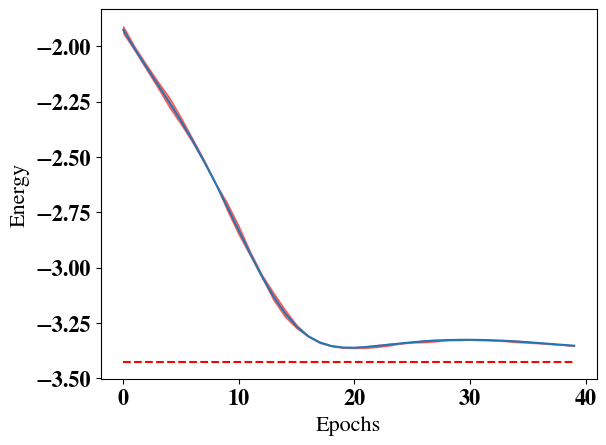

In [27]:
from functools import partial

sample_size = 20000

seed = 1

E_hist=[]
E_smpl_hist=[]

rbm = RBM_surrogate(N=N,M=M,seed=seed,)
x = tf.Variable(rbm.X)

tm=time.time()

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=epsilon)

for epoch in range(40):
  rbm = RBM_surrogate(N,M,X=x.numpy())
  rbm.build_surrogate()

  #tm = time.time()
  prob_func = partial(prob_Ising_nv, N=N, poly=rbm.poly, log_rho_max=rbm.log_rho_max)
  prob_dist = Sampling(N=N, prob_func=prob_func, sample_size=sample_size, burn=sample_size//10)
  #print("Sampling Time: ", time.time()-tm)


  E = rbm.Energy_exact(Ham)

  #tm = time.time()
  E_smpl = rbm.Energy_sampling(Ham,prob_mat=prob_dist)
  #print("Energy Time: ", time.time()-tm)
  print(epoch, "Energy: ", E, "\t +/- \t", np.abs(E_smpl - E))

  #tm = time.time()
  #grad_exact = np.real(rbm.grad_exact(Ham))
  grad = np.real(rbm.grad_Sampling(Ham,prob_mat=prob_dist))
  #print("Gradient Time: ", time.time()-tm)

  optimizer.apply_gradients([(grad, x)])

  E_hist.append(E)
  E_smpl_hist.append(E_smpl)

print("\n\n\nEnergy: ",E,"\n Time",time.time()-tm, lmbd[0])

plot_log(E_hist, E_smpl_hist)
save_data(rbm.X,rbm.poly,g,seed,E,E_smpl,prob_dist,sample_list=[])

In [28]:
rbm.X

array([-0.0209428 , -0.19796048, -0.30481155, -0.30226256, -0.09946225,
       -0.48172511,  0.37547785, -0.30421908, -0.08689306, -0.22787215,
        0.30171643, -0.39795843, -0.22907338, -0.28615423,  0.36225798,
       -0.33983588, -0.267143  , -0.30722285,  0.25716354, -0.19530607,
       -0.30888255, -0.10432028,  0.19908776, -0.00713847,  0.01708475,
        0.18832148, -0.15647368,  0.03652987,  0.11247059,  0.26215283,
       -0.03589472, -0.20537435,  0.02102989, -0.20015063, -0.27995892,
       -0.09440247, -0.10590066,  0.25883819,  0.36080864, -0.01441756,
        0.15404985, -0.27077511, -0.3099548 ,  0.01897262, -0.09294122,
        0.11619909,  0.18558005,  0.04758918])